In [41]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg


IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


In [6]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [7]:
df = pd.read_csv("medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [11]:
df.describe()
print(df.shape)

(1964, 9)


In [5]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found")
  assert (n > 0)

In [6]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [7]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [8]:
rootdir = "medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [9]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [10]:
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

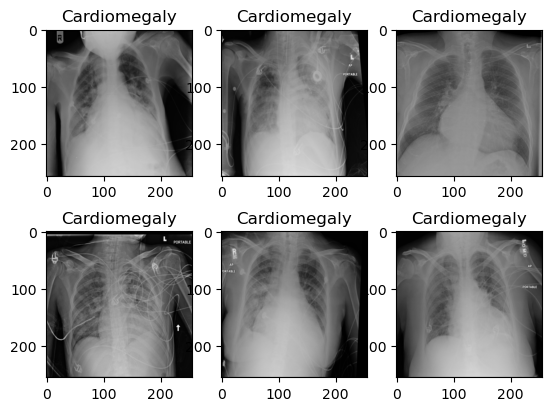

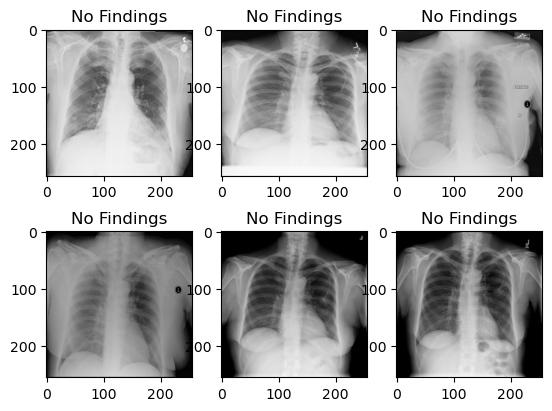

In [11]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [12]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) 
x = layers.Dense(1024, activation='relu')(x) 
x = layers.Dropout(0.2)(x) 
x = layers.Dense(1, activation='sigmoid')(x) 

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 16s 0us/step
Done compiling the model!


In [16]:
# Define our example directories and files
base_dir = rootdir = "medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


In [25]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
232/232 - 413s - loss: 4.0909 - acc: 0.5991 - val_loss: 0.8870 - val_acc: 0.6833 - 413s/epoch - 2s/step
Epoch 2/20
232/232 - 388s - loss: 1.1665 - acc: 0.7069 - val_loss: 0.6754 - val_acc: 0.6000 - 388s/epoch - 2s/step
Epoch 3/20
232/232 - 396s - loss: 0.7222 - acc: 0.6379 - val_loss: 0.9071 - val_acc: 0.5167 - 396s/epoch - 2s/step
Epoch 4/20
232/232 - 369s - loss: 0.5797 - acc: 0.7155 - val_loss: 0.6087 - val_acc: 0.7000 - 369s/epoch - 2s/step
Epoch 5/20
232/232 - 410s - loss: 0.5696 - acc: 0.7069 - val_loss: 0.4574 - val_acc: 0.7833 - 410s/epoch - 2s/step
Epoch 6/20
232/232 - 404s - loss: 0.5782 - acc: 0.6940 - val_loss: 0.7439 - val_acc: 0.5333 - 404s/epoch - 2s/step
Epoch 7/20
232/232 - 403s - loss: 0.4700 - acc: 0.7845 - val_loss: 0.4280 - val_acc: 0.8167 - 403s/epoch - 2s/step
Epoch 8/20
232/232 - 401s - loss: 0.4768 - acc: 0.7716 - val_loss: 0.5203 - val_acc: 0.7333 - 401s/epoch - 2s/step
Epoch 9/20
232/232 - 406s - loss: 0.4748 - acc: 0.7672 - val_loss: 0.4351 - val_

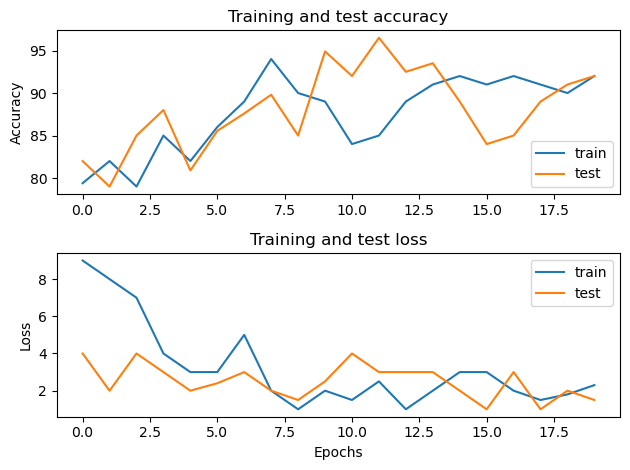

In [37]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


In [38]:
train_accuracy = history.history['acc'][-1] * 100
val_accuracy = history.history['val_acc'][-1] * 100
print(f'Training Accuracy: {train_accuracy:.2f}%')
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Training Accuracy: 93.15%
Validation Accuracy: 93.23%


In [27]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [28]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 78ms/step
Done inference!


1/1 [==============================] - 0s 74ms/step


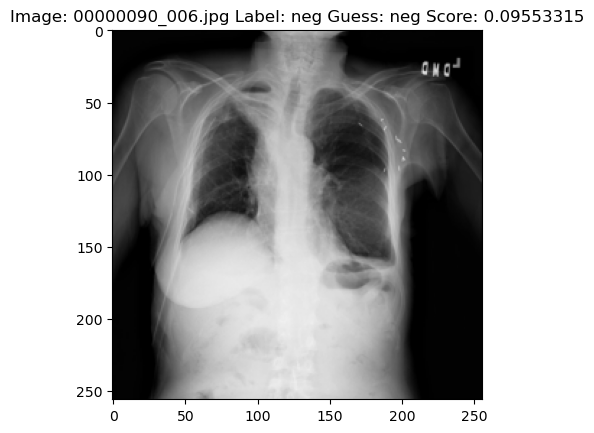

In [29]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [30]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.993570
5,00004344_013.jpg,pos,pos,0.786720
10,00019861_010.jpg,pos,pos,0.567159
15,00012686_003.jpg,pos,neg,0.438083
20,00028607_000.jpg,pos,neg,0.334005
25,00000092_000.jpg,neg,neg,0.269017
30,00008522_032.jpg,pos,neg,0.215054
35,00000090_002.jpg,neg,neg,0.157019
40,00000090_006.jpg,neg,neg,0.095533
45,00000091_007.jpg,neg,neg,0.060348


In [33]:
model.save('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

INFO:tensorflow:Assets written to: /content/export/Cardiomegaly/assets


INFO:tensorflow:Assets written to: /content/export/Cardiomegaly/assets


  adding: content/export/Cardiomegaly/ (stored 0%)
  adding: content/export/Cardiomegaly/keras_metadata.pb (deflated 96%)
  adding: content/export/Cardiomegaly/saved_model.pb (deflated 92%)
  adding: content/export/Cardiomegaly/fingerprint.pb (stored 0%)
  adding: content/export/Cardiomegaly/variables/ (stored 0%)
  adding: content/export/Cardiomegaly/variables/variables.data-00000-of-00001 (deflated 41%)
  adding: content/export/Cardiomegaly/variables/variables.index (deflated 78%)
  adding: content/export/Cardiomegaly/assets/ (stored 0%)


In [43]:
import tensorflow as tf
import gradio as gr
import numpy as np
from PIL import Image

finding = "cardiomegaly"  
saved_model_path = '/content/export/Cardiomegaly'
loaded_model = tf.keras.models.load_model(saved_model_path)

def classify_image(image):
    image_pil = Image.fromarray((image*255).astype('uint8'))
    image_resized = image_pil.resize((256, 256))  
    image_np = np.array(image_resized)
    image_normalized = image_np / 255.0
    image_expanded = np.expand_dims(image_normalized, axis=0)
    prediction = loaded_model.predict(image_expanded)[0][0]
    return f"Prediction: {'Positive' if prediction > 0.5 else 'Negative'} (Confidence: {prediction:.2f})"

input_component = gr.Image()

iface = gr.Interface(fn=classify_image, inputs=input_component, outputs="text")
iface.launch(share = 'true')

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://5518c70aa49a703550.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 115ms/step
